<a href="https://colab.research.google.com/github/vigkrishna/Facial-Recognition-with-PyTorch/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/parth1620/Facial-Expression-Dataset.git
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

Cloning into 'Facial-Expression-Dataset'...
remote: Enumerating objects: 34052, done.
remote: Total 34052 (delta 0), reused 0 (delta 0), pack-reused 34052 (from 1)
Receiving objects: 100% (34052/34052), 52.31 MiB | 21.75 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (35887/35887), done.
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-h3oj1jtq
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-h3oj1jtq
  Resolved https://github.com/albumentations-team/albumentations to commit 2bc1c14bc14463df085145fc9e632a0256adc4f9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 26.8 MB/s eta 0:00:00
  Created wheel for albumentations: filename

**IMPORTS --------**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

**CONFIGURATIONS ------**

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jonathanoheix/face-expression-recognition-dataset")

print("Path to dataset files:", path)

100%|██████████| 121M/121M [00:03<00:00, 33.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jonathanoheix/face-expression-recognition-dataset/versions/1


In [4]:
TRAIN_IMG_FOLDER_PATH = '/content/Facial-Expression-Dataset/train'
VALID_IMG_FOLDER_PATH = '/content/Facial-Expression-Dataset/validation'


lr = 0.01
BATCH_SIZE=32
epochs =15

device ='cuda'
model_name = 'efficientnet_b0'

In [5]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as T

In [6]:
train_augs = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=(-20,+20)),
    T.ToTensor()
])

valid_augs = T.Compose([
    T.ToTensor()
])

In [7]:
trainset = ImageFolder(TRAIN_IMG_FOLDER_PATH,transform = train_augs)
validset = ImageFolder(VALID_IMG_FOLDER_PATH,transform = valid_augs)



print(f"Total no. of examples in trainset : {len(trainset)}")
print(f"Total no. of examples in validset : {len(validset)}")

Total no. of examples in trainset : 28821
Total no. of examples in validset : 7066


Text(0.5, 1.0, '0')

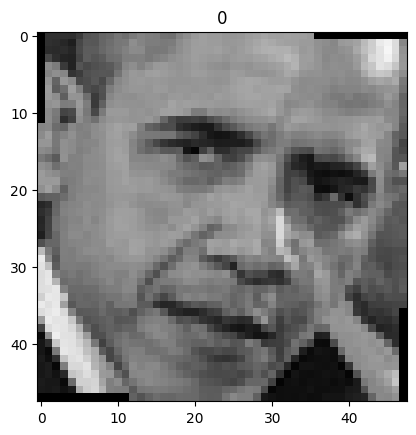

In [8]:
image,label = trainset[3000]

plt.imshow(image.permute(1,2,0))  # (c,w,h) format
plt.title(label)

In [9]:
print(trainset.class_to_idx)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


**Loading Dataset into Batches**

In [10]:
from torch.utils.data import DataLoader

In [11]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = T)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

**Creating the model**

In [12]:

import timm
from torch import nn

class FERModel(nn.Module):
    def __init__(self):
        super(FERModel, self).__init__()
        self.eff_net = timm.create_model('efficientnet_b0', pretrained=True,num_classes=7)


    def forward(self, images,labels=None):
        logits = self.eff_net(images)


        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)
            return logits,loss

        return logits

model = FERModel()
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

**Create Train and Eval Function**

In [13]:
!pip install tqdn

In [14]:
from tqdm import tqdm

In [15]:
def multiclass_accuracy(y_pred,y_true):
  top_p,top_class = y_pred.topk(1,dim=1)
  equals = top_class == y_true.view(*top_class.shape)
  return torch.mean(equals.type(torch.FloatTensor))

In [16]:
def train_fn(model,dataloader,optimizer,current_epo):
  model.train()
  train_loss = 0
  train_acc = 0
  total_loss=0
  total_acc=0
  tk = tqdm(dataloader,desc = "epoc" + "{TRAIN}" + str(current_epo + 1) + "/" + str(epochs))


  for t, data in enumerate(tk):
    images,labels = data
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    logits,loss = model(images,labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits,labels)
    tk.set_postfix({'loss' : loss.item(),'acc' : multiclass_accuracy(logits,labels)})


  return total_loss / len(dataloader),total_acc / len(dataloader)


In [17]:
def eval_fn(model,dataloader,optimizer,current_epo):
  model.eval()
  train_loss = 0
  train_acc = 0
  total_loss=0
  total_acc=0
  tk = tqdm(dataloader,desc = "epoc" + "{VALID}" + str(current_epo + 1) + "/" + str(epochs))


  for t, data in enumerate(tk):
    images,labels = data
    images = images.to(device)
    labels = labels.to(device)


    logits,loss = model(images,labels)


    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits,labels)
    tk.set_postfix({'loss' : loss.item(),'acc' : multiclass_accuracy(logits,labels)})


  return total_loss / len(dataloader),total_acc / len(dataloader)

**CREATING THE TRAINING LOOP**

In [18]:
optimizer = torch.optim.Adam(model.parameters(),lr = lr)

In [19]:

best_valid_loss = np.Inf

for i in range(epochs):
    train_loss, train_acc = train_fn(model, trainloader, optimizer, i)  # Pass model, not model_name
    valid_loss, valid_acc = eval_fn(model, validloader, optimizer, i)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model_weights.pt')
        print("Saved model weights")


epoc{VALID}1/15: 100%|██████████| 221/221 [00:06<00:00, 32.19it/s, loss=3.31, acc=tensor(0.5385)]


Saved model weights


epoc{VALID}2/15: 100%|██████████| 221/221 [00:06<00:00, 35.32it/s, loss=1.24, acc=tensor(0.6154)]


Saved model weights


epoc{VALID}3/15: 100%|██████████| 221/221 [00:06<00:00, 34.78it/s, loss=0.874, acc=tensor(0.6923)]


Saved model weights


epoc{VALID}4/15: 100%|██████████| 221/221 [00:06<00:00, 32.05it/s, loss=1, acc=tensor(0.6923)]


Saved model weights


epoc{VALID}5/15: 100%|██████████| 221/221 [00:06<00:00, 36.08it/s, loss=0.743, acc=tensor(0.7692)]


Saved model weights


epoc{VALID}7/15: 100%|██████████| 221/221 [00:06<00:00, 35.72it/s, loss=1.65, acc=tensor(0.3846)]


Saved model weights


epoc{VALID}8/15: 100%|██████████| 221/221 [00:06<00:00, 32.34it/s, loss=0.587, acc=tensor(0.8846)]


Saved model weights


epoc{VALID}11/15: 100%|██████████| 221/221 [00:06<00:00, 33.36it/s, loss=1.6, acc=tensor(0.5000)]


Saved model weights


epoc{VALID}12/15: 100%|██████████| 221/221 [00:06<00:00, 35.93it/s, loss=0.746, acc=tensor(0.6923)]


Saved model weights


epoc{VALID}13/15: 100%|██████████| 221/221 [00:06<00:00, 32.12it/s, loss=0.771, acc=tensor(0.7692)]


Saved model weights


epoc{VALID}14/15: 100%|██████████| 221/221 [00:06<00:00, 35.48it/s, loss=0.703, acc=tensor(0.7692)]


Saved model weights


epoc{VALID}15/15: 100%|██████████| 221/221 [00:06<00:00, 32.81it/s, loss=0.744, acc=tensor(0.6923)]


**INFERENCE**

In [21]:
import torch
from torchvision import transforms as T
from PIL import Image


model = FERModel()
model.load_state_dict(torch.load('best_model_weights.pt'))
model.eval()
model.to(device)


inference_transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
])

def predict_image(image_path):
    image = Image.open(image_path)
    image = inference_transforms(image).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(image)
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()


    class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    predicted_class_name = class_names[predicted_class]

    return predicted_class_name, probabilities


image_path = 'img_path'
predicted_label, probabilities = predict_image(image_path)

print(f"Predicted Class: {predicted_label}")
print(f"Probabilities: {probabilities}")

<ipython-input-21-8c4dd15f1deb>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_weights.pt'))


Predicted Class: Angry
Probabilities: tensor([[9.3120e-01, 1.3073e-06, 1.3935e-04, 4.4857e-02, 1.9223e-03, 2.1868e-02,
         1.2058e-05]], device='cuda:0')
